In [1]:
import numpy as np
import tensorflow as tf

import os
# np.random.seed(1337)  # for reproducibility
# tf.random.set_seed(1337)
# os.environ['TF_DETERMINISTIC_OPS'] = '1'
# os.environ['TF_CUDNN_DETERMINISTIC '] = '1'


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

In [2]:
base_coin_str = 'BTC'
base_coin_fullname_str = 'bitcoin'

In [3]:
from data.utils import load_data
from data.scaling import normalize

filtro_tipos_eventos_permitidos = ['listing', 'launch', 'fork']
query_str = 'title.isna()'
for filtro in filtro_tipos_eventos_permitidos:
    query_str += f' or title.str.lower().str.contains("{filtro}")'
    # df = df.query(f'event_title.isna() or event_title.str.lower().str.contains("{filtro}")')
print(query_str)

title.isna() or title.str.lower().str.contains("listing") or title.str.lower().str.contains("launch") or title.str.lower().str.contains("fork")


In [4]:
df = load_data(base_coin_str, base_coin_fullname_str, event_days_left_lookback=7, storage_folder='../data', events_query=query_str)
prices, _ = normalize(df.loc[:, 'price'].to_numpy())
variation = df.loc[:, 'price (%)'].to_numpy()
# variation = df.loc[:, 'price'].pct_change().fillna(0).to_numpy()
volume, _ = normalize(df['Volume'].to_numpy())
volume_variation = df['Volume'].pct_change().fillna(0).to_numpy()
tweet, _ = normalize(df.loc[:, 'tweet_volume'].to_numpy())
tweet_variation = df.loc[:, 'tweet_volume'].pct_change().fillna(0).to_numpy()
google_trends, _ = normalize(df.loc[:, 'trend'].to_numpy())
google_trends_variation = df.loc[:, 'trend'].pct_change().fillna(0).to_numpy()

In [6]:
from typing import Tuple
# look_behind: passos (dias) anteriores usados para prever o proximo.
N = 30
foward_days = 1  # quantos dias prever

def to_keras_format(features: list, target) -> Tuple[np.array, np.array]:
    n_samples = len(target) - N - (foward_days-1)
    # matriz de dimensao: [n_samples, N, n_features];
    features_set = np.empty((n_samples, N, len(features)))  # type: np.ndarray
    labels = [None]*n_samples
    for i in range(n_samples):
        for j in range(N):
            for ft_idx in range(len(features)):
                feature = features[ft_idx]
                features_set[i, j, ft_idx] = feature[i+j]

        labels[i] = target[N+i-1: N+i+foward_days]
    labels = np.array(labels)

    return features_set, labels

In [7]:
from keras.models import Model
from keras.layers import Input, LSTM, Dropout, Dense

def build_model(train_X, train_y) -> Model:
    inputs = Input(shape=train_X.shape[1:])
    lstm = LSTM(units=750, return_sequences=False, input_shape=train_X.shape[1:])(inputs)
    lstm = Dropout(0.1)(lstm)
    x = Dense(units=175, activation='linear')(lstm)
    x = Dropout(0.1)(x)
    x = Dense(units=75, activation='linear')(x)
    x = Dropout(0.1)(x)
    x = Dense(units=foward_days)(x)
    return Model(inputs=inputs, outputs=x)

In [8]:
from matplotlib import pyplot as plt
# vizualizando estatisticas do modelo em si e seu treino
def plot_train_history(modelo: Model, plot_above_or_below_zero_accuracy: bool, plotValidation = True, figsize=(25,10)):
    plt.rcParams['figure.figsize'] = figsize
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2)

    ax1.plot(modelo.history.history['loss'])
    if plotValidation: ax1.plot(modelo.history.history['val_loss'])
    ax1.title.set_text('model loss')
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epoch')
    ax1.legend(['train', 'test'], loc='upper left')

    ax2.plot(modelo.history.history['mean_squared_error'])
    if plotValidation: ax2.plot(modelo.history.history['val_mean_squared_error'])
    ax2.title.set_text('model meanSquaredError')
    ax2.set_ylabel('mse')
    ax2.set_xlabel('epoch')
    ax2.legend(['train', 'test'], loc='upper left')

    ax3.plot(modelo.history.history['movement_accuracy'])
    if plotValidation: ax3.plot(modelo.history.history['val_movement_accuracy'])
    ax3.title.set_text('model movement direction accuracy')
    ax3.set_ylabel('accuracy')
    ax3.set_xlabel('epoch')
    ax3.legend(['train', 'test'], loc='upper left')

    # plote esse apenas se seu dado target for de variação (não faz sentido para dado bruto)
    if plot_above_or_below_zero_accuracy:
        ax4.plot(modelo.history.history['above_or_below_zero_accuracy'])
        if plotValidation: ax4.plot(modelo.history.history['val_above_or_below_zero_accuracy'])
        ax4.title.set_text('price up or down accuracy *')
        ax4.set_ylabel('accuracy')
        ax4.set_xlabel('epoch')
        ax4.legend(['train', 'test'], loc='upper left')
    plt.tight_layout()
    plt.show()

In [14]:
# tf.keras.backend.clear_session() #limpa modelos e dados anteriores, para evitar vazamento de memoria
from metrics.custom import above_or_below_zero_accuracy, movement_accuracy
from metrics.custom import mean_squared_error, cosine_similarity as custom_cosine_similarity
from metrics.custom import RootMeanSquaredError

from sklearn.model_selection import KFold, RepeatedKFold
from shutil import rmtree

def get_model_name(k, n_repeat = None):
    if n_repeat:
        return 'model_'+str(k)+'_'+str(n_repeat)+'.h5'
    return 'model_'+str(k)+'.h5'


def build_and_run_and_show(features, target, loss_function, shuffle_mask=None, epochs=400, batch_size=128) -> Model:
    save_dir = './tmp/altcoins/saved_models/'    
    if os.path.exists(save_dir):
        rmtree(save_dir)

    features_set, labels = to_keras_format(features, target)

    if shuffle_mask == None:
        shuffle_mask = np.arange(len(features_set))
        np.random.shuffle(shuffle_mask)

    unshuffle_mask = np.zeros(len(shuffle_mask), dtype=int)
    for i in range(len(shuffle_mask)):
        unshuffle_mask[shuffle_mask[i]] = i

    features_set, labels = features_set[shuffle_mask], labels[shuffle_mask]

    
    TEST_MSE, TEST_MOV_ACCURACY, TEST_UPDOWN_ACCURACY, TEST_RMSE, TEST_NRMSE = [], [], [], [], []
    # kf = KFold(n_splits = 5)
    n_repeats = 2
    kf = RepeatedKFold(n_splits = 5, n_repeats = n_repeats, random_state=1337) # random_state fixo para manter reproducibilidade entre chamadas dessa função

    fold_num = 1
    repeat_num = 1
    for train_index, test_index  in kf.split(features_set, labels):
        tf.keras.backend.clear_session()

        train_X, train_y = features_set[train_index], labels[train_index]
        test_X, test_y = features_set[test_index], labels[test_index]

        model = build_model(train_X, train_y)
        opt = tf.keras.optimizers.Adam(learning_rate=0.001, amsgrad=True)
        model.compile(optimizer=opt, loss=loss_function, metrics=[mean_squared_error, movement_accuracy, above_or_below_zero_accuracy, RootMeanSquaredError()])# 'cosine_similarity', 'mean_squared_error'

        # CREATE CALLBACKS
        best_mse_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mse/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_mean_squared_error:.5f}', 
                                monitor='val_mean_squared_error', verbose=0, save_best_only=True, mode='min')
        best_movAcc_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'mov_accuracy/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_movement_accuracy:.5f}', 
                                monitor='val_movement_accuracy', verbose=0, save_best_only=True, mode='max')
        best_above_below_zero_checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir+'above_or_below_zero_accuracy/'+get_model_name(fold_num, repeat_num),#+'_{epoch:03d}-{val_movement_accuracy:.5f}', 
                                monitor='val_above_or_below_zero_accuracy', verbose=0, save_best_only=True, mode='max')
        checkpoints = [best_mse_checkpoint, best_movAcc_checkpoint, best_above_below_zero_checkpoint]

        print(f'treinando fold {fold_num}, repetição {repeat_num} (400 epochs dá 2min +-)')
        model.fit(train_X, train_y, validation_data=(test_X, test_y), epochs=epochs, batch_size=batch_size, callbacks=checkpoints, verbose=0)
        

        # PLOT HISTORY
        plot_train_history(model, plot_above_or_below_zero_accuracy=True, figsize=(25,8))

        # LOAD BEST MODEL (for specific metric) to evaluate the performance of the model
        model.load_weights(save_dir+"mse/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_MSE.append(results['mean_squared_error'])
        TEST_RMSE.append(results['root_mean_squared_error'])
        TEST_NRMSE.append(results['root_mean_squared_error']/(test_y.max() - test_y.min()))
        
        model.load_weights(save_dir+"mov_accuracy/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_MOV_ACCURACY.append(results['movement_accuracy'])

        model.load_weights(save_dir+"above_or_below_zero_accuracy/"+get_model_name(fold_num, repeat_num))
        results = model.evaluate(x=test_X, y=test_y, batch_size=1)
        results = dict(zip(model.metrics_names, results))
        TEST_UPDOWN_ACCURACY.append(results['above_or_below_zero_accuracy'])

        if repeat_num % n_repeats == 0:
            fold_num +=1
            repeat_num = 1
        else:    
            repeat_num += 1        

        rmtree(save_dir)
        tf.keras.backend.clear_session()

    print('\nResults:\n')
    print(f'MeanSquaredError: {TEST_MSE}')
    print(f'RootMeanSquaredError: {TEST_RMSE}')
    print(f'NormalizedRootMeanSquaredError: {TEST_NRMSE}')
    print(f'MovementDiretionAccuracy: {TEST_MOV_ACCURACY}')
    print(f'AboveOrBellowAccuracy: {TEST_UPDOWN_ACCURACY}\n')
    print(f'MeanSquaredError mean: {np.mean(TEST_MSE)}')
    print(f'RootMeanSquaredError: {np.mean(TEST_RMSE)}')
    print(f'NormalizedRootMeanSquaredError: {np.mean(TEST_NRMSE)}')
    print(f'MovementDiretionAccuracy mean: {np.mean(TEST_MOV_ACCURACY)}')
    print(f'AboveOrBellowAccuracy mean: {np.mean(TEST_UPDOWN_ACCURACY)}\n')
    print(f'MeanSquaredError std: {np.std(TEST_MSE)}')
    print(f'MovementDiretionAccuracy std: {np.std(TEST_MOV_ACCURACY)}')
    print(f'AboveOrBellowAccuracy std: {np.std(TEST_UPDOWN_ACCURACY)}')

    return

# Executando

## Testa a perfomance treinando com moeda base e prevendo moeda alternativa

treinando fold 1, repetição 1 (400 epochs dá 2min +-)


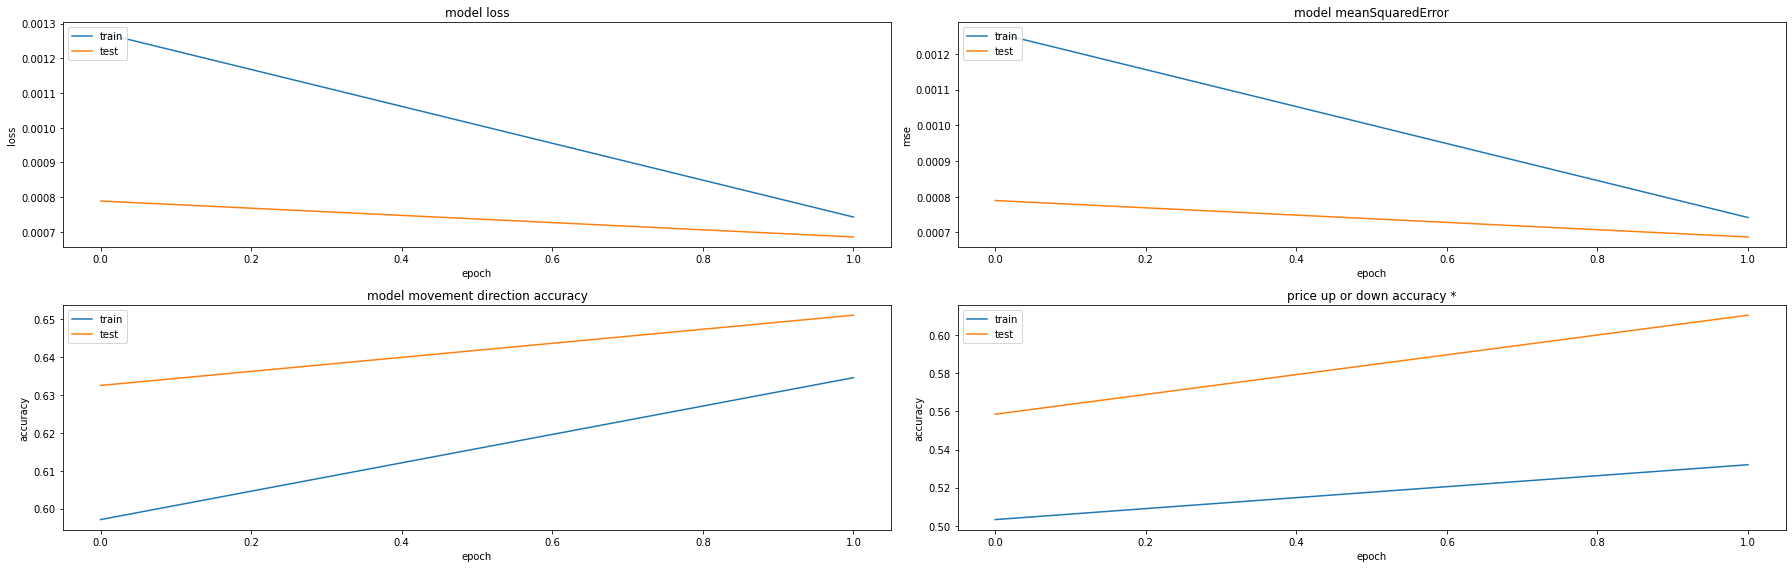

498/498 [==============================] - 9s 19ms/step - loss: 6.8489e-04 - mean_squared_error: 6.8489e-04 - movement_accuracy: 0.6526 - above_or_below_zero_accuracy: 0.6104 - root_mean_squared_error: 0.0262
treinando fold 1, repetição 2 (400 epochs dá 2min +-)


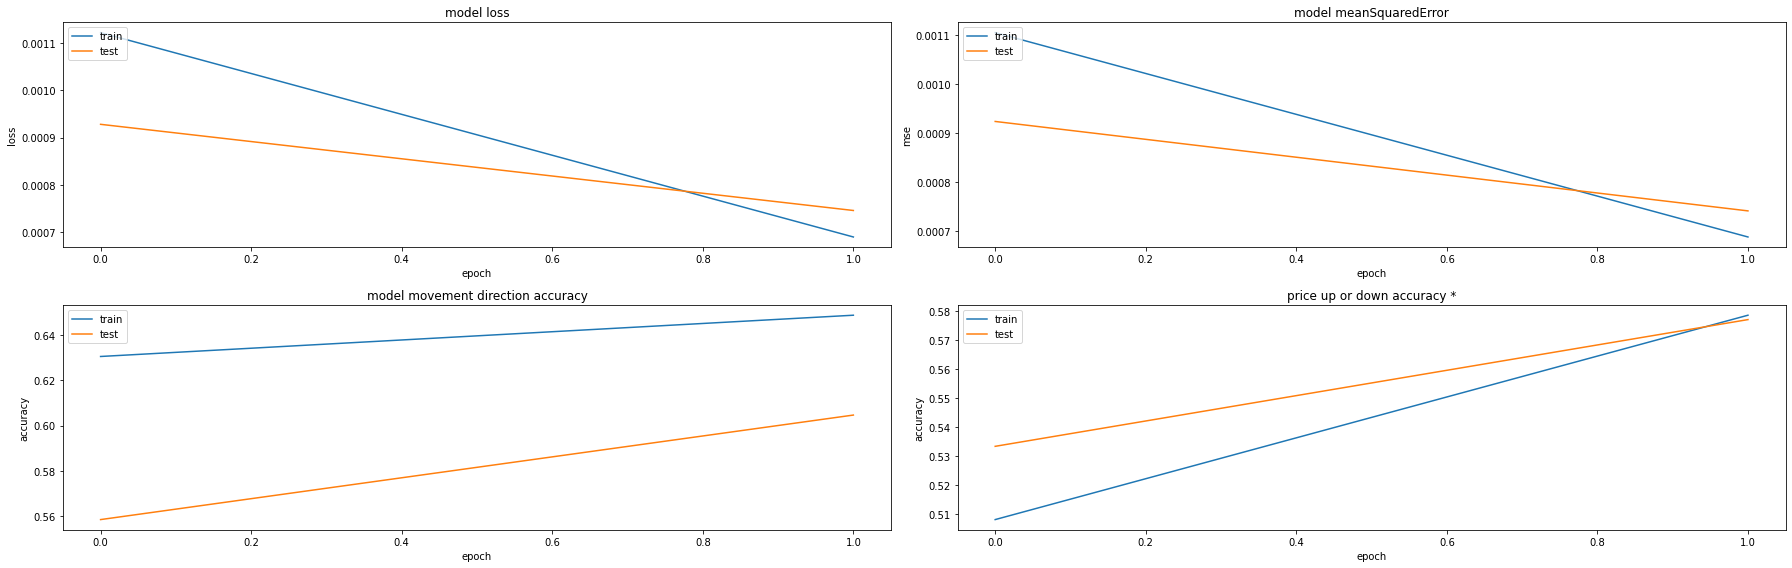

498/498 [==============================] - 11s 22ms/step - loss: 7.4576e-04 - mean_squared_error: 7.4576e-04 - movement_accuracy: 0.6044 - above_or_below_zero_accuracy: 0.5783 - root_mean_squared_error: 0.0273
treinando fold 2, repetição 1 (400 epochs dá 2min +-)


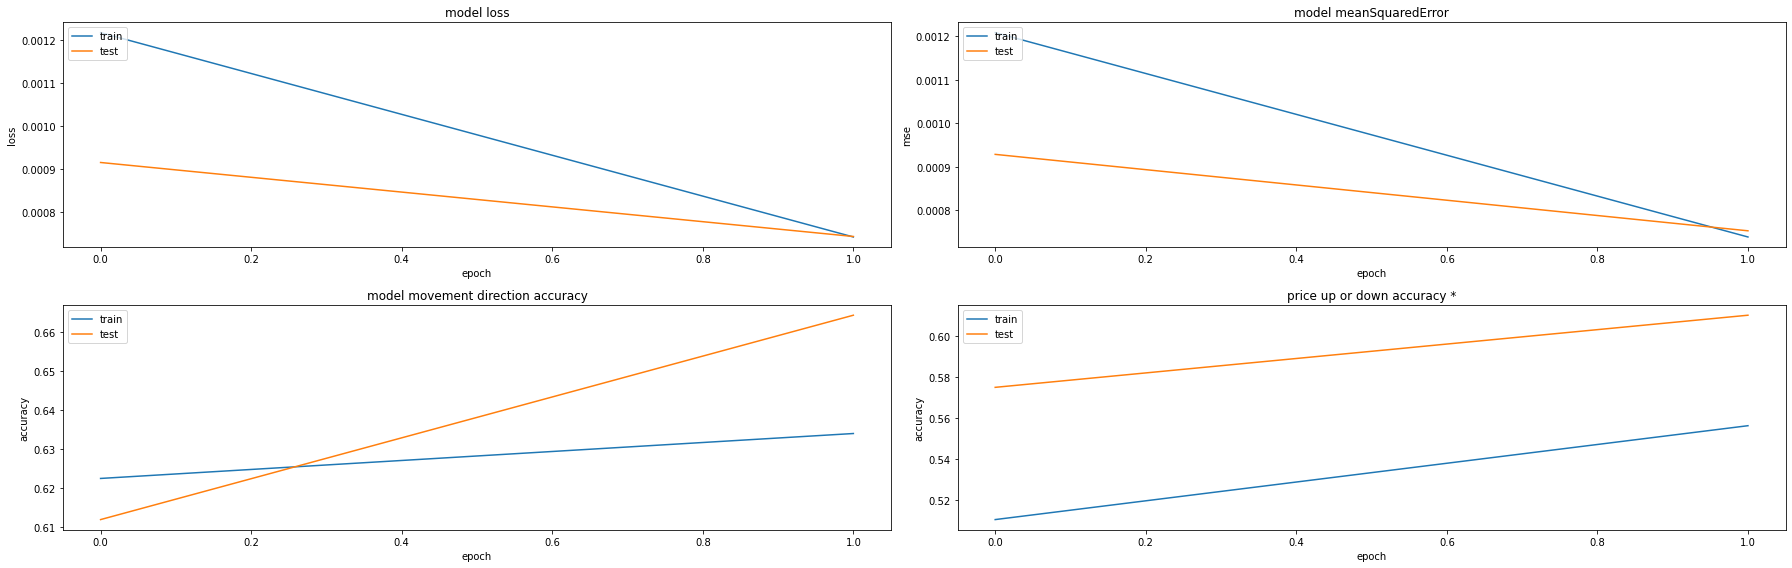

497/497 [==============================] - 16s 32ms/step - loss: 7.4328e-04 - mean_squared_error: 7.4328e-04 - movement_accuracy: 0.6660 - above_or_below_zero_accuracy: 0.6097 - root_mean_squared_error: 0.0273
treinando fold 2, repetição 2 (400 epochs dá 2min +-)


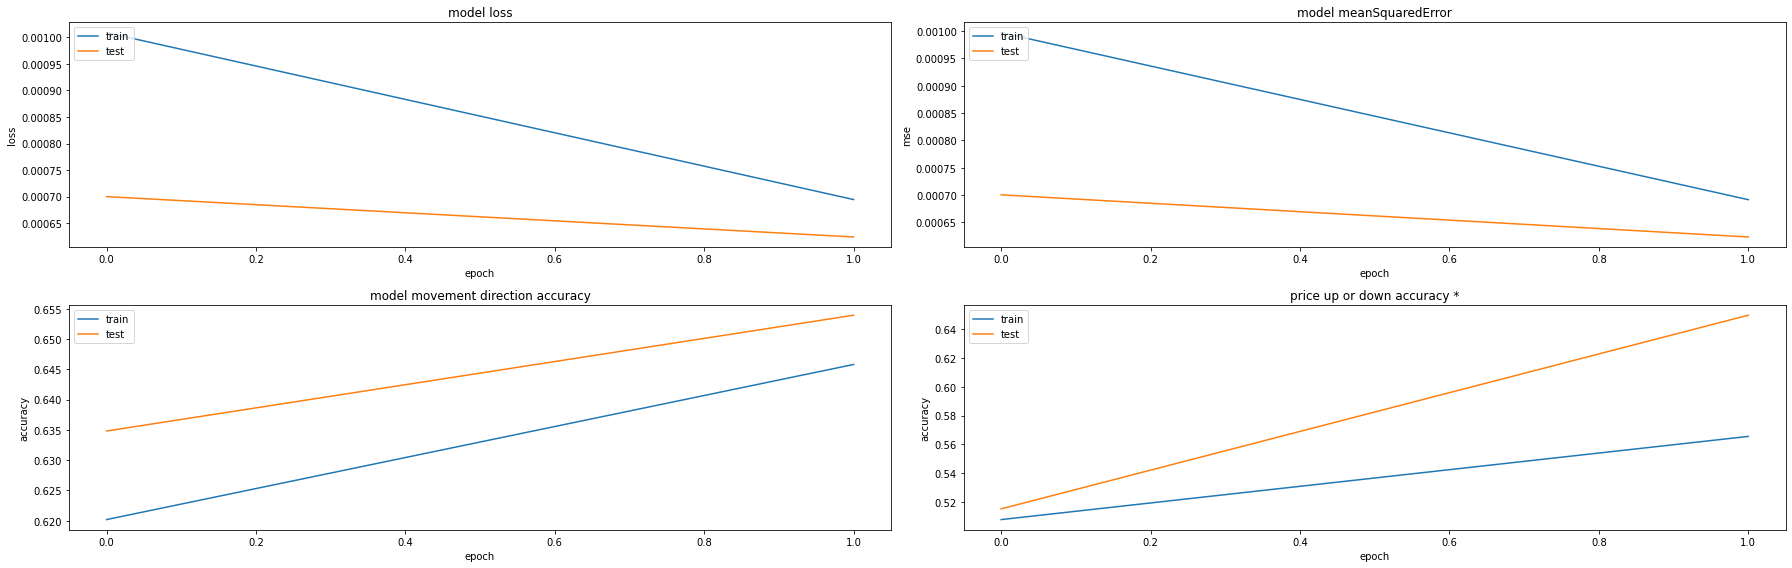

497/497 [==============================] - 13s 26ms/step - loss: 6.2416e-04 - mean_squared_error: 6.2416e-04 - movement_accuracy: 0.6539 - above_or_below_zero_accuracy: 0.6479 - root_mean_squared_error: 0.0250
treinando fold 3, repetição 1 (400 epochs dá 2min +-)


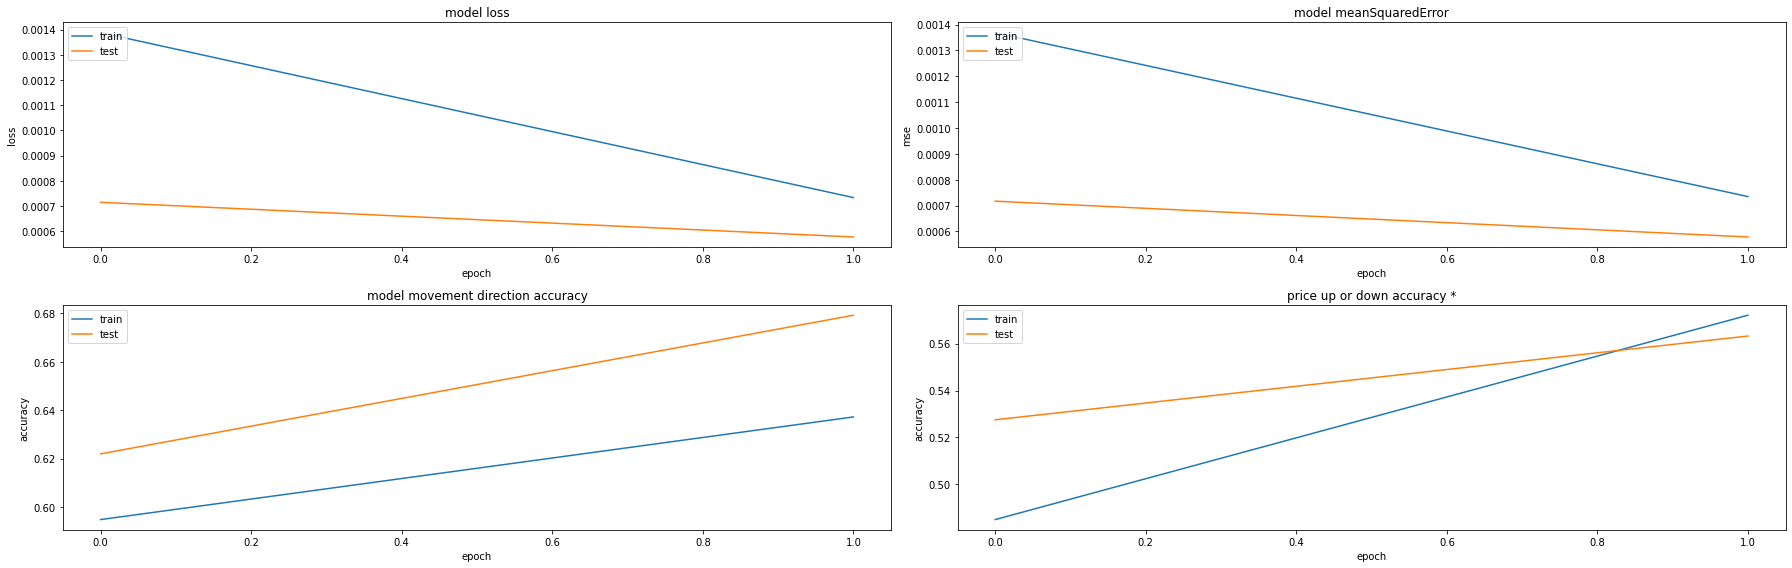

497/497 [==============================] - 16s 31ms/step - loss: 5.7713e-04 - mean_squared_error: 5.7713e-04 - movement_accuracy: 0.6781 - above_or_below_zero_accuracy: 0.5634 - root_mean_squared_error: 0.0240
treinando fold 3, repetição 2 (400 epochs dá 2min +-)


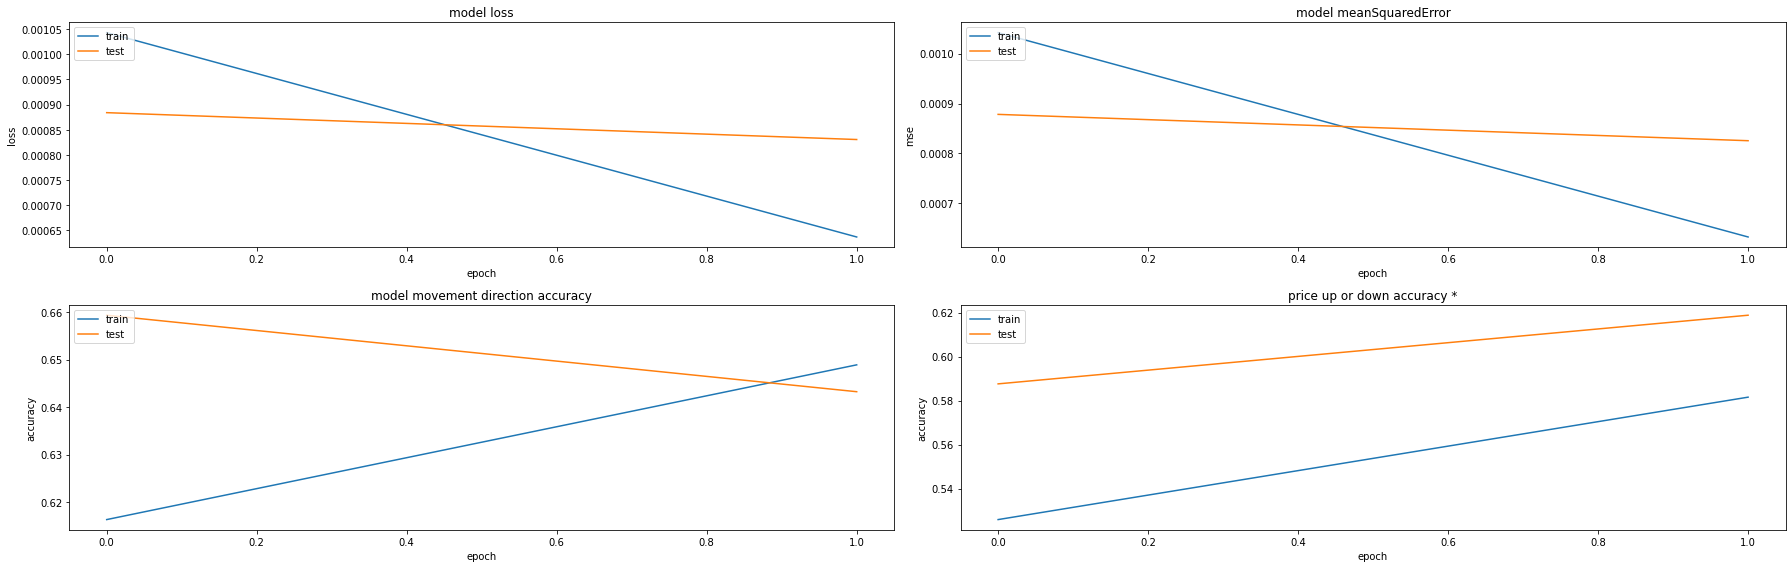

498/498 [==============================] - 17s 35ms/step - loss: 8.3067e-04 - mean_squared_error: 8.3067e-04 - movement_accuracy: 0.6426 - above_or_below_zero_accuracy: 0.6185 - root_mean_squared_error: 0.0288
treinando fold 4, repetição 1 (400 epochs dá 2min +-)


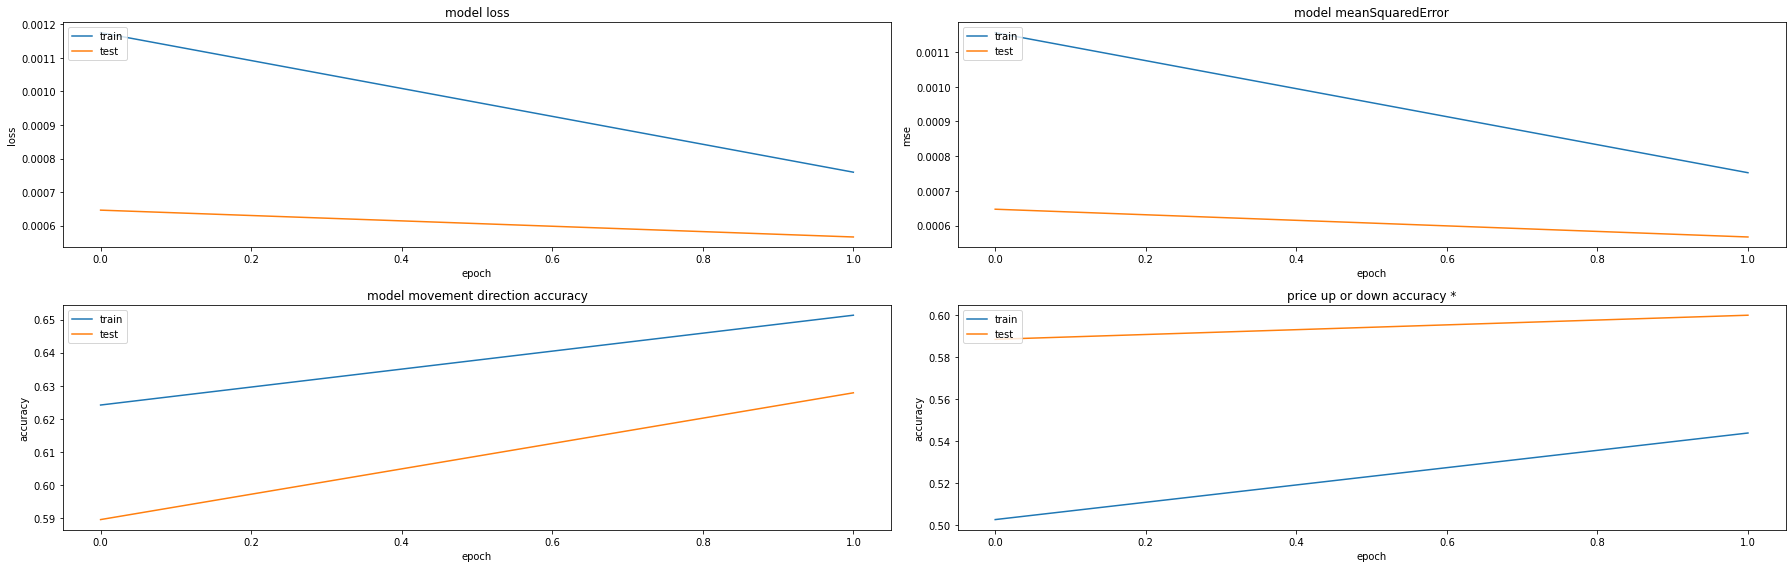

498/498 [==============================] - 17s 33ms/step - loss: 5.6612e-04 - mean_squared_error: 5.6612e-04 - movement_accuracy: 0.6285 - above_or_below_zero_accuracy: 0.6004 - root_mean_squared_error: 0.0238
treinando fold 4, repetição 2 (400 epochs dá 2min +-)


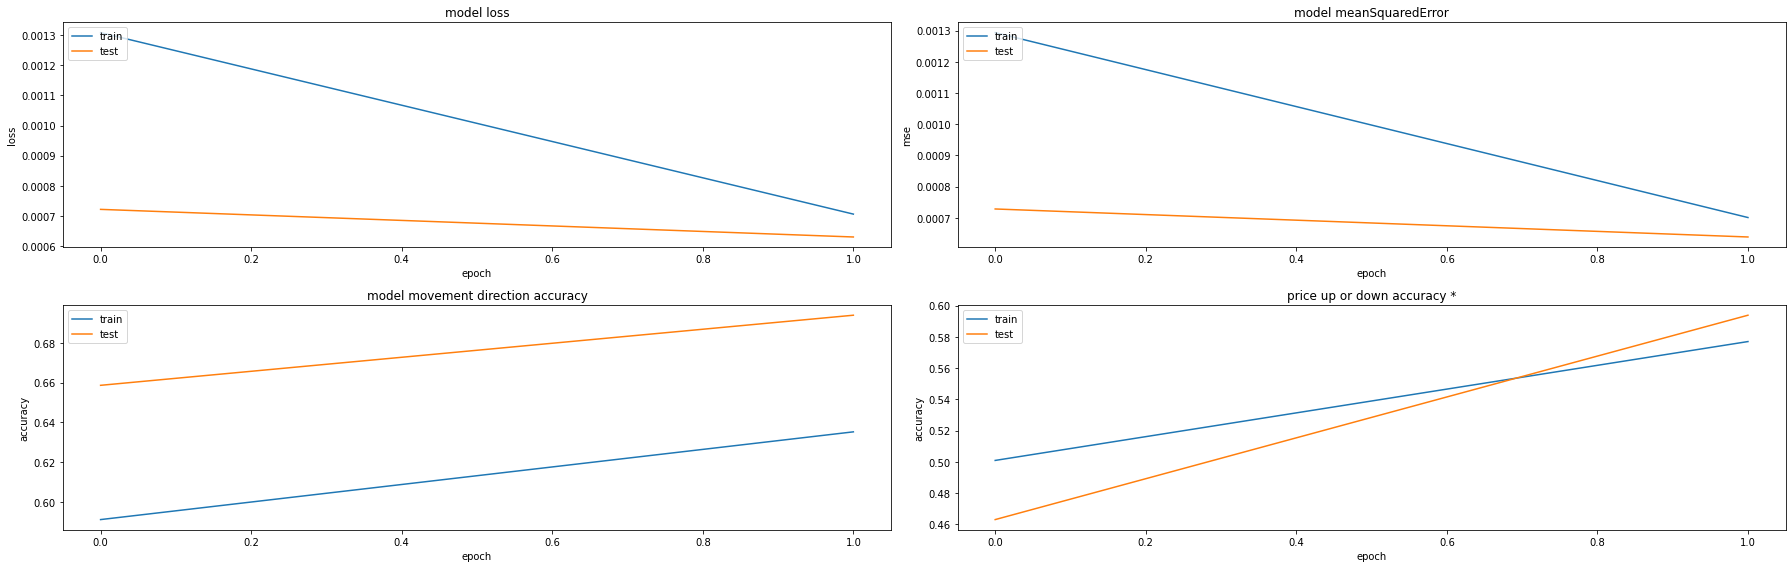

497/497 [==============================] - 18s 36ms/step - loss: 6.3020e-04 - mean_squared_error: 6.3020e-04 - movement_accuracy: 0.6942 - above_or_below_zero_accuracy: 0.5936 - root_mean_squared_error: 0.0251
treinando fold 5, repetição 1 (400 epochs dá 2min +-)


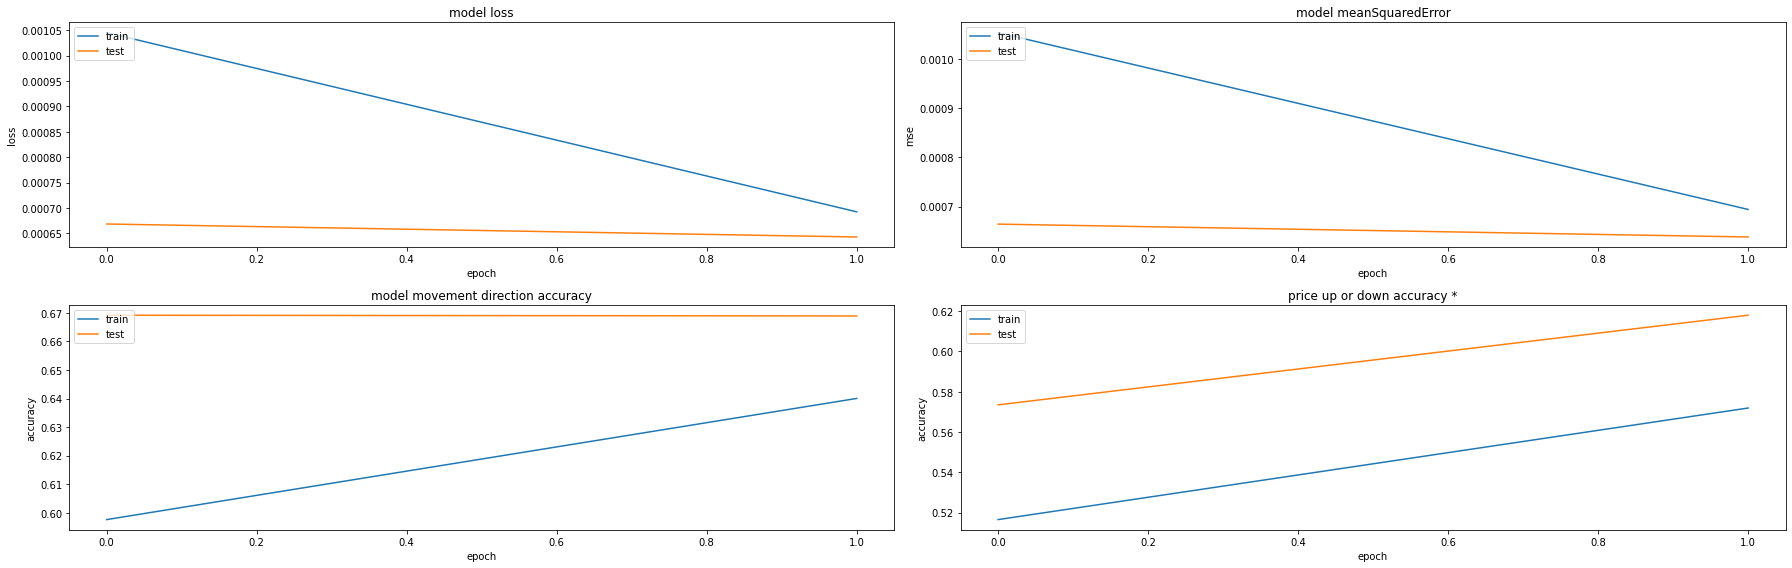

497/497 [==============================] - 18s 36ms/step - loss: 6.4297e-04 - mean_squared_error: 6.4297e-04 - movement_accuracy: 0.6680 - above_or_below_zero_accuracy: 0.6177 - root_mean_squared_error: 0.0254
treinando fold 5, repetição 2 (400 epochs dá 2min +-)


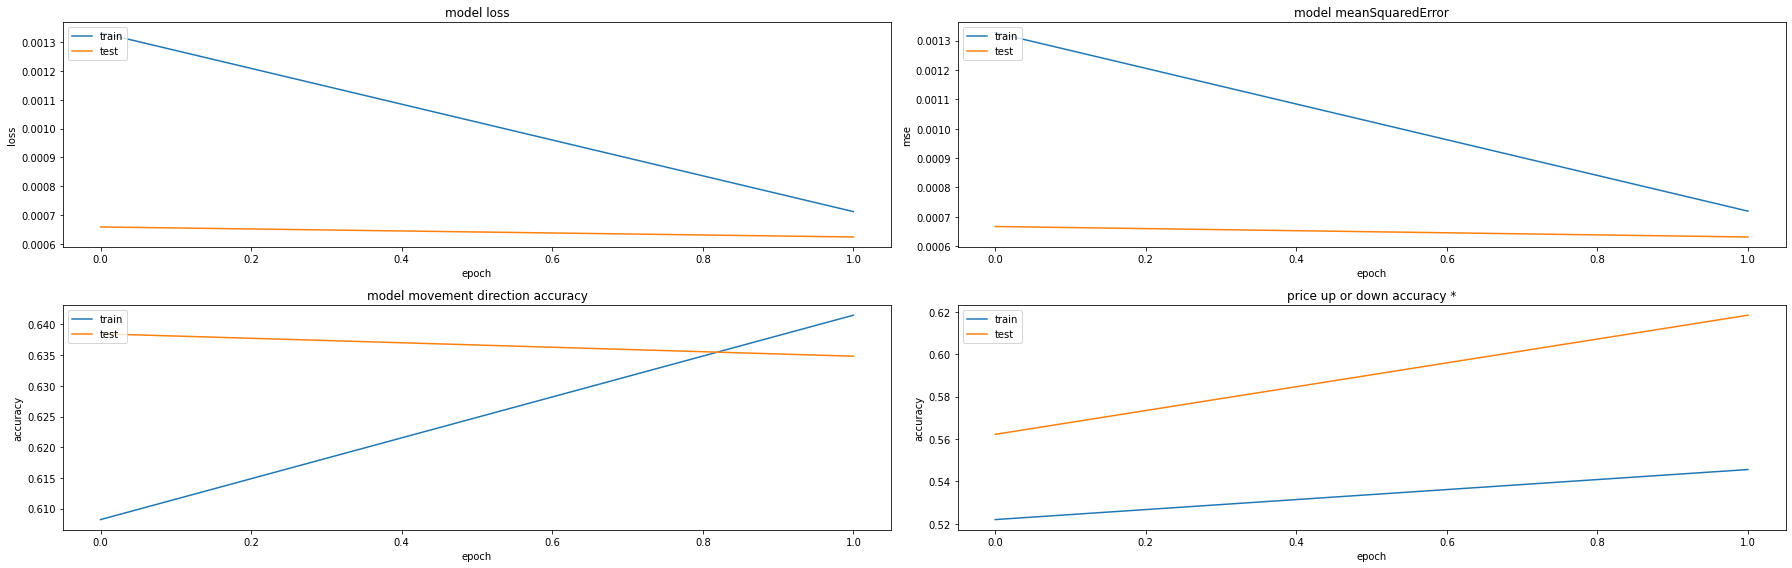

497/497 [==============================] - 16s 32ms/step - loss: 6.2339e-04 - mean_squared_error: 6.2339e-04 - movement_accuracy: 0.6358 - above_or_below_zero_accuracy: 0.6197 - root_mean_squared_error: 0.0250

Results:

MeanSquaredError: [0.0006848912453278899, 0.0007457552710548043, 0.0007432842976413667, 0.0006241596420295537, 0.0005771289579570293, 0.0008306697709485888, 0.0005661167087964714, 0.000630200607702136, 0.0006429693312384188, 0.0006233915337361395]
RootMeanSquaredError: [0.026170426979660988, 0.027308519929647446, 0.02726324088871479, 0.024983186274766922, 0.0240235086530447, 0.028821341693401337, 0.023793207481503487, 0.025103796273469925, 0.02535684034228325, 0.02496781013906002]
NormalizedRootMeanSquaredError: [0.08948489366962335, 0.06617921343671423, 0.09219907457769887, 0.07045442856630055, 0.10888763102631892, 0.06984537164130017, 0.10533832540110902, 0.09172716608442676, 0.07476988340035855, 0.08536594828960155]
MovementDiretionAccuracy: [0.6526104211807251, 0.6

In [15]:
features = [variation]
target = variation

build_and_run_and_show(features, target, mean_squared_error,epochs=600)

# old

desvio padrao

correlação

In [14]:
import pandas as pd
import numpy as np
def variation_to_price(base_price, prices, predictions):
    predicted_prices = np.zeros_like(predictions)
    print(f'predicted_prices: {predicted_prices}')
    # n_samples = len(prices) - N - (foward_days-1)
    last_price = base_price
    for i in range(len(prices)):
        print(f'last_price: {last_price}')
        predicted_prices[i] = last_price + (last_price * predictions[i])
        print(f'predicted_prices: {predicted_prices}')
        last_price = prices[i]
    return predicted_prices

l1 = [1.0,1.5,1.0,0.5,2.0,0.01]
l1 = pd.DataFrame(l1).iloc[:,0]
l2 = l1.pct_change().fillna(0).to_numpy()
l1 = l1.to_numpy()
print(l1)
print(l2)

print('\n')
r = variation_to_price(l1[0], l1[1:], l2[1:])
print(r)

[1.   1.5  1.   0.5  2.   0.01]
[ 0.          0.5        -0.33333333 -0.5         3.         -0.995     ]


predicted_prices: [0. 0. 0. 0. 0.]
last_price: 1.0
predicted_prices: [1.5 0.  0.  0.  0. ]
last_price: 1.5
predicted_prices: [1.5 1.  0.  0.  0. ]
last_price: 1.0
predicted_prices: [1.5 1.  0.5 0.  0. ]
last_price: 0.5
predicted_prices: [1.5 1.  0.5 2.  0. ]
last_price: 2.0
predicted_prices: [1.5  1.   0.5  2.   0.01]
[1.5  1.   0.5  2.   0.01]
